**In this notebook, we will implement multiple linear regression using scikit-learn and predict CO2 emissions of unobserved cars based on selected features. We will create, train and test a linear regression model on real data. This notebook is based on IBM Skills Network's Machine Learning with Python course.**

In [1]:
# # download necessary packages
# !pip install numpy==2.2.0
# !pip install pandas==2.2.3
# !pip install scikit-learn==1.6.0
# !pip install matplotlib==3.9.3

In [2]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Load the data

In [3]:
#We will use the dataset that resides in the following url directly with the pandas library to load the dataset

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"

In [4]:
df = pd.read_csv(url)

In [5]:
#Let's verify if the dataset is successfully loaded by selecting some random records
df.sample(5)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
572,2014,JEEP,CHEROKEE 4X4,SUV - SMALL,3.2,6,A9,X,12.5,8.8,10.8,26,248
337,2014,FIAT,500 HATCHBACK,MINICOMPACT,1.4,4,A6,X,8.7,6.9,7.9,36,182
319,2014,DODGE,DART GT,MID-SIZE,2.4,4,A6,X,10.6,7.5,9.2,31,212
679,2014,LINCOLN,MKT AWD,SUV - STANDARD,3.5,6,AS6,X,14.8,10.4,12.8,22,294
75,2014,BENTLEY,MULSANNE,MID-SIZE,6.8,8,AS8,Z,22.3,14.9,19.0,15,437


# Understanding the data

We are using a fuel consumption dataset which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada.



*   MODEL YEAR e.g., 2014
*   MAKE e.g., VOLVO


*   MODEL e.g., S60 AWD
*   VEHICLE CLASS e.g., COMPACT

*   ENGINE SIZE e.g., 3.0

*   CYLINDERS e.g., 6

*   TRANSMISSION e.g., AS6

*  FUEL TYPE e.g.,Z

*   FUEL CONSUMPTION IN CITY (L/100km) e.g., 13.2

*   FUEL CONSUMPTION IN HWY (L/100 KM) e.g., 9.5
*   FUEL CONSUMPTION COMBINED (L/100KM) e.g., 9.5


*   FUEL CONSUMPTION COMBINED (L/100 KM) e.g., 11.5


*   FUEL CONSUMPTION COMBINED MPG (MPG) e.g. 25


*   CO2 EMISSIONS (g/km) e.g. 182

We will create a simple linear regression model from one of these features to predict CO2 emissions of unobserved cars based on that feature.







# DATA EXPLORATION

In [6]:
# consider the statistical summary of the data

df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


We can notice that the non numerical features were not included in the model description. In practice, we would analyse these features if required to improve the accuracy of our model, but we omit this step here in this notebook. Also the variable MODELYEAR is the same for all the cars so we can drop these variables.

In [7]:
# drop categoricals and any other useless columns

df = df.drop(['MODELYEAR','MAKE','MODEL','VEHICLECLASS','TRANSMISSION','FUELTYPE'],axis=1)

Now that we eliminated some features, lets take a look at the relationships among the remaining features.
Analyzing a correlation matrix that displays the pairwise correlations between all features indicates the level of independence between them. It also indicates how predictive each feature is of to the target.

We want to eliminate any strong dependencies or correlations between features by selecting the best one from each correlated group.

In [8]:
df.corr()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
ENGINESIZE,1.000000,0.934011,0.832225,0.778746,0.819482,-0.808554,0.874154
CYLINDERS,0.934011,1.000000,0.796473,0.724594,0.776788,-0.770430,0.849685
FUELCONSUMPTION_CITY,0.832225,0.796473,1.000000,0.965718,0.995542,-0.935613,0.898039
FUELCONSUMPTION_HWY,0.778746,0.724594,0.965718,1.000000,0.985804,-0.893809,0.861748
FUELCONSUMPTION_COMB,0.819482,0.776788,0.995542,0.985804,1.000000,-0.927965,0.892129
FUELCONSUMPTION_COMB_MPG,-0.808554,-0.770430,-0.935613,-0.893809,-0.927965,1.000000,-0.906394
CO2EMISSIONS,0.874154,0.849685,0.898039,0.861748,0.892129,-0.906394,1.000000


From the bottom row which shows the correlation between each variable and the target 'CO2EMISSIONS', we notice that each of these variables shows a fairly high level of correlation, each exceeding 85% in magnitude. Thus all of these features are good candidates.

Now lets examine the correlations of the distinct pairs. 'ENGINESIZE' and 'CYLINDERS' are highly correlated (0.934). But, ENGINESIZE is more correlated with the target (0.874) than CYLINDERS (0.849). So we can drop CYLINDERS.

Similarly, each of the four fuel economy variables is highly correlated with each other. Since, FUELCONSUMPTION_COMB_MPG is the most correlated with the target (-0.906) than the others, we can drop the other three.

Notice that FUELCONSUMPTION_COMB and FUELCONSUMPTION_COMB_MPG are not perfectly correlated. They should be, though, because they measure the same property in different units. In practice, we would investigate why this is the case. We might find out that some or all of the data is not useable as is.

In [9]:
df = df.drop(['CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB'],axis=1)

In [10]:
df.head(6)

,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244
5,3.5,28,230


In [11]:
import seaborn as sns

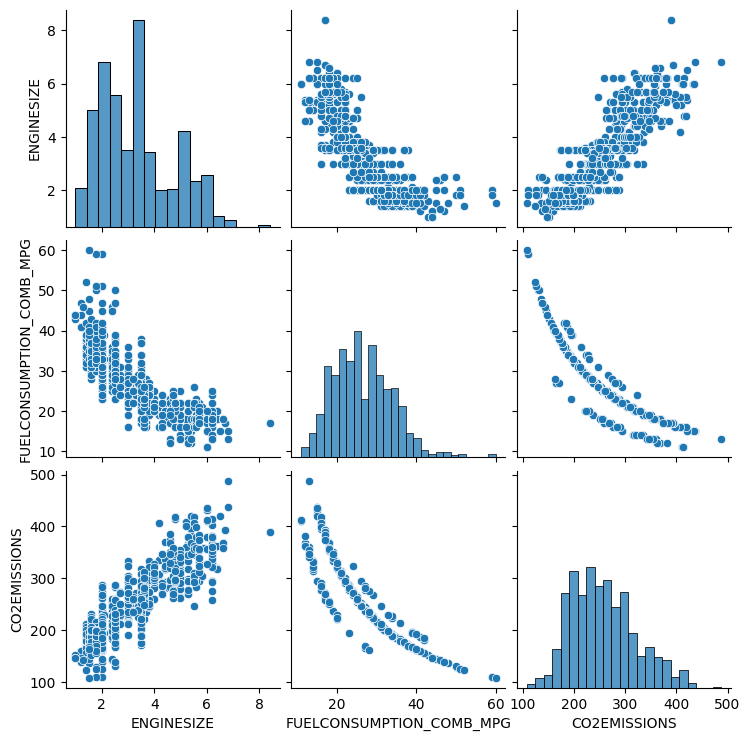

In [12]:
sns.pairplot(df)

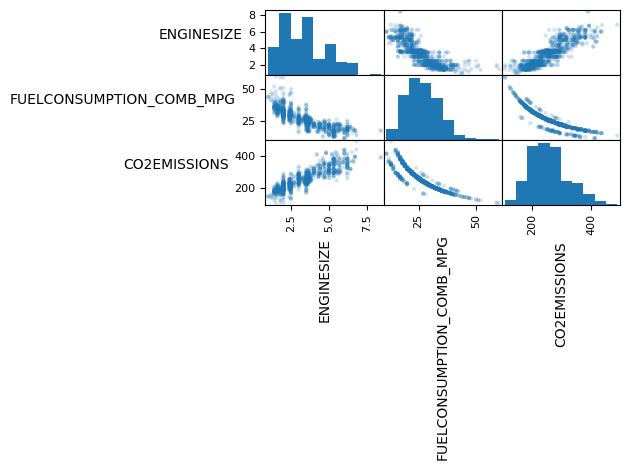

In [13]:
#scatter plots can be plotted using pandas as well as shown below
axes = pd.plotting.scatter_matrix(df, alpha=0.2)
# need to rotate axis labels so we can read them
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

From the scatter plots, we can notice that the relationship between FUELCONSUMPTION_COMB_MPG and CO2EMISSIONS is non-linear. We ignore the concept of non-linearity throughout this notebook..

# Extract the input features and labels from the data set

Lets extract the required columns and convert the resulting dataframes to numpy arrays.

In [14]:
df.head()

,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244


In [15]:
X = df.iloc[:,[0,1]].to_numpy()
y = df.iloc[:,[2]].to_numpy()


# Preprocess selected features

We should standardize our input features so the model doesn't inadvertently favor any feature due to its magnitude. The typical way to do it is to subtract the mean and divide by the standard deviation. We can do this by using StandardScaler() method from scikit learn.

In [16]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)

### Why use fit_transform?

With scalers like StandardScaler, fit() learns the scaling parameters (here- mean and std dev of each feature) and transform() actually applies those learned parameters to scale our data. fit_transform() does both in one step ie., learns + applies.

Also, in practice, we don't use the scaler on all our input data because this might cause data leakage. If we use the scaler on our entire dataset, we are essentially letting the scaler 'peek' at all the data (both train + test). This means even our test data (which is supposed to be unseen) is influencing the transformation as well. So in practice, we first split the dataset into training and testing sets and use the scaler only on the training data.

In [17]:
pd.DataFrame(X_std).describe().round(2)

,0,1
count,1067.00,1067.00
mean,0.00,-0.00
std,1.00,1.00
min,-1.66,-2.07
25%,-0.95,-0.73
50%,0.04,-0.06
75%,0.67,0.61
max,3.57,4.50


As we can see, our standardized variable has zero mean and a standard deviation of one.

# Create train and test datasets

Lets randomly split our data into train and test sets, using 80% of the dataset for training and reserving the remaining 20% for testing.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# Build a multiple regression model

In [19]:
from sklearn import linear_model

#create a model object
regressor = linear_model.LinearRegression()

#train the model in the training data
regressor.fit(X_train,y_train)

#Print the coefficients
coef_ = regressor.coef_
intercept_ = regressor.intercept_

print('Coefficients: ', coef_)
print('Intercept: ', intercept_)

Coefficients:  [[ 25.27339614 -37.4381472 ]]
Intercept:  [256.29072488]


In [20]:
type(coef_)

numpy.ndarray

The coefficients and intercept parameters define the best fit hyperplane to the data. Since there are only two variables, hence two parameters, the hyperplane is a plane. But this best-fit plane will look different in the original, unstandardized feature space.

We can transform our model's parameters back to the original space prior to standardization as follows. This gives us a proper sense of what they mean in terms of our original input features. Without these adjustments, the model's outputs would be tied to an abstract, transformed space that doesn't align with the actual independent variables and the real world problems we're solving.

In [21]:
# Get the standard scaler's mean and standard deviation parameters
means_ = std_scaler.mean_
std_devs_ = np.sqrt(std_scaler.var_)
print(means_,std_devs_)


[ 3.34629803 26.44142455] [1.4152314  7.46520131]


In [22]:
# The least squares parameters can be calculated relative to the original unstandardized feature space as:
coef_original = coef_/std_devs_
intercept_original = intercept_ - np.sum(means_*coef_/std_devs_)

print('Coefficients: ',coef_original)
print('Intercept: ',intercept_original)

Coefficients:  [[17.8581369  -5.01502179]]
Intercept:  [329.1363967]


Looking at the non-zero intercept, we can say that the target variable doesn't have a very strong linear relationship to the dependent variables, and/or the data has outliers that are biasing the result. Outliers can be handled in preprocessing, or by using regularization techniques. One or more of the variables might have a non linear relationship to the target. Or there may still be some collinearity amongst the input variables.

# Visualize model outputs

Lets visualize the goodness-of-fit of the model to the training data by plotting the fitted plane over the data.

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
print(coef_)

[[ 25.27339614 -37.4381472 ]]


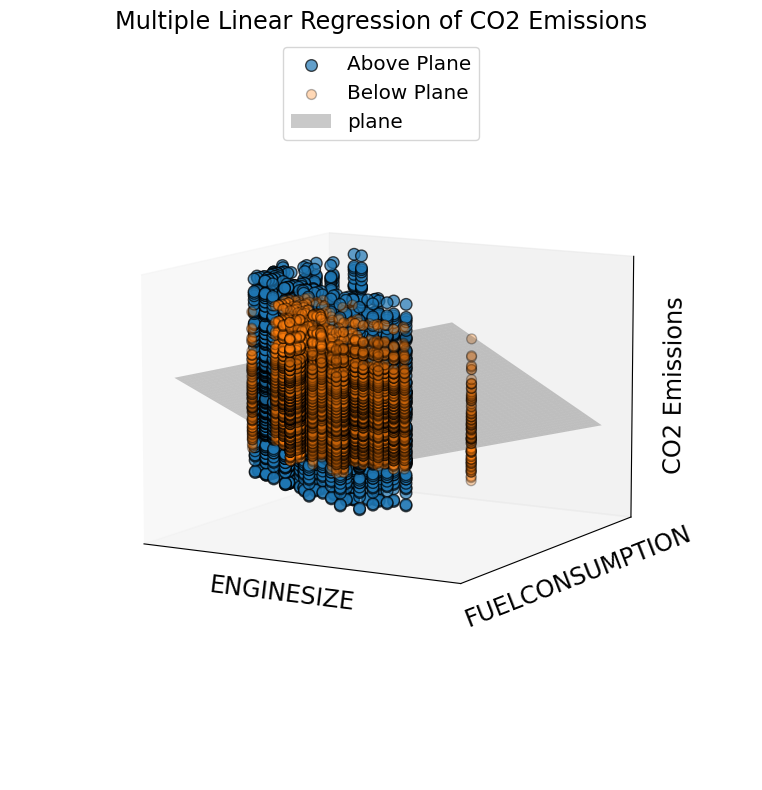

In [25]:
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Ensure X1, X2, and y_test have compatible shapes for 3D plotting
X1 = X_test[:, 0] if X_test.ndim > 1 else X_test
X2 = X_test[:, 1] if X_test.ndim > 1 else np.zeros_like(X1)

# Create a mesh grid for plotting the regression plane
x1_surf, x2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
                               np.linspace(X2.min(), X2.max(), 100))

y_surf = intercept_ +  coef_[0,0] * x1_surf  +  coef_[0,1] * x2_surf

# Predict y values using trained regression model to compare with actual y_test for above/below plane colors
y_pred = regressor.predict(X_test.reshape(-1, 1)) if X_test.ndim == 1 else regressor.predict(X_test)
above_plane = y_test >= y_pred
below_plane = y_test < y_pred
above_plane = above_plane[:,0]
below_plane = below_plane[:,0]

# Plotting
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane],  label="Above Plane",s=70,alpha=.7,ec='k')
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane],  label="Below Plane",s=50,alpha=.3,ec='k')

# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='k', alpha=0.21,label='plane')

# Set view and labels
ax.view_init(elev=10)

ax.legend(fontsize='x-large',loc='upper center')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel('ENGINESIZE', fontsize='xx-large')
ax.set_ylabel('FUELCONSUMPTION', fontsize='xx-large')
ax.set_zlabel('CO2 Emissions', fontsize='xx-large')
ax.set_title('Multiple Linear Regression of CO2 Emissions', fontsize='xx-large')

# %matplotlib notebook
plt.tight_layout()
plt.show()


Instead of making a 3d plot, which is difficult to interpret, we can look at vertical slices of the 3d plot by plotting each varibale separately as a best fit line using the corresponding regression parameters.

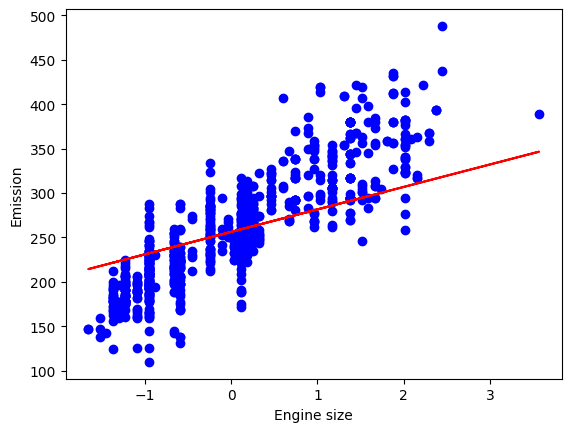

In [26]:
plt.scatter(X_train[:,0], y_train,  color='blue')
plt.plot(X_train[:,0], coef_[0,0] * X_train[:,0] + intercept_[0], '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

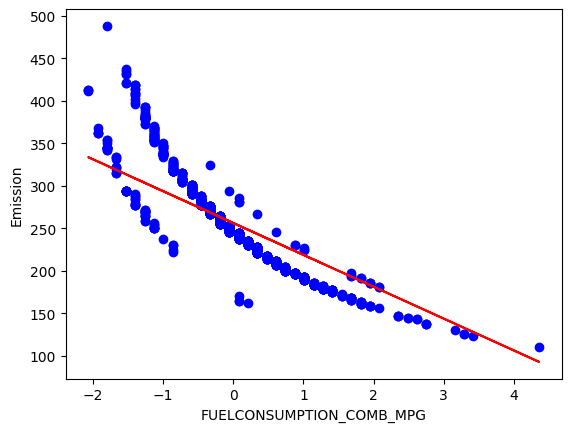

In [27]:
plt.scatter(X_train[:,1], y_train,  color='blue')
plt.plot(X_train[:,1], coef_[0,1] * X_train[:,1] + intercept_[0], '-r')
plt.xlabel("FUELCONSUMPTION_COMB_MPG")
plt.ylabel("Emission")
plt.show()

Evidently, the solution is incredibly poor because the model is trying to fit a plane to a non-planar surface.

Lets determine and print the parameters for the best-fit linear regression line for CO2 emission with respect to engine size.

In [39]:
X_train_1 = pd.DataFrame(X_train).iloc[:,[0]].to_numpy()

In [41]:
regressor_1 = linear_model.LinearRegression()
regressor_1.fit(X_train_1,y_train)
coef_1 = regressor_1.coef_
intercept_1 = regressor_1.intercept_

print('Coefficients: ',coef_1)
print('Intercept: ', intercept_1)

Coefficients:  [[55.18408797]]
Intercept:  [256.77183014]


Lets now produce a scatterplot of CO2 emission against ENGINESIZE and include the best-fit regression line to the training data.

Text(0, 0.5, 'Emission')

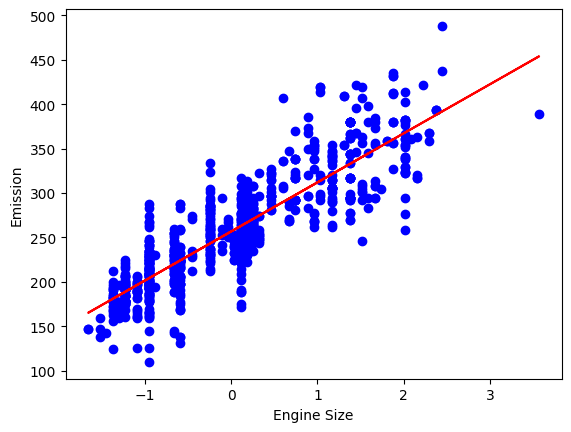

In [43]:
plt.scatter(X_train_1,y_train,color='blue')
plt.plot(X_train_1,coef_1[0] * X_train_1 + intercept_1,'-r')
plt.xlabel('Engine Size')
plt.ylabel('Emission')

Lets now plot basing the result on the test data.

In [54]:
X_test_1 = X_test[:,[0]]

In [55]:
X_test_1.shape

(214, 1)

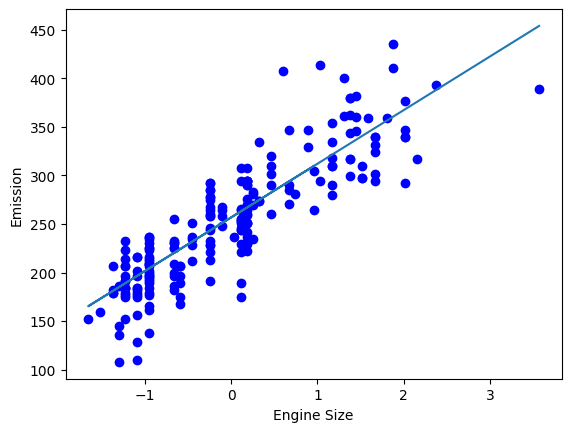

In [58]:
plt.scatter(X_test_1.reshape(-1,1),y_test,color='blue')
plt.plot(X_test_1,coef_1[0]*X_test_1+intercept_1)
plt.xlabel('Engine Size')
plt.ylabel('Emission')
plt.show()

Lets repeat the same modeling but use FUELCONSUMPTION_COMB_MPG as the independent variable instead.

In [59]:
X_train_2 = pd.DataFrame(X_train).iloc[:,[1]].to_numpy()

regressor_2 = linear_model.LinearRegression()
regressor_2.fit(X_train_2,y_train)
coef_2 = regressor_2.coef_
intercept_2 = regressor_2.intercept_

print('Coefficients: ',coef_2)
print('Intercept: ', intercept_2)

Coefficients:  [[-58.51827989]]
Intercept:  [256.09392179]


Text(0, 0.5, 'Emission')

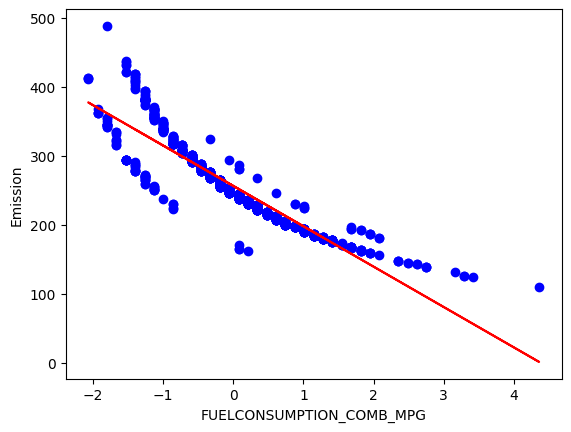

In [60]:
# plotting the training data
plt.scatter(X_train_2,y_train,color='blue')
plt.plot(X_train_2,coef_2[0] * X_train_2 + intercept_2,'-r')
plt.xlabel('FUELCONSUMPTION_COMB_MPG')
plt.ylabel('Emission')

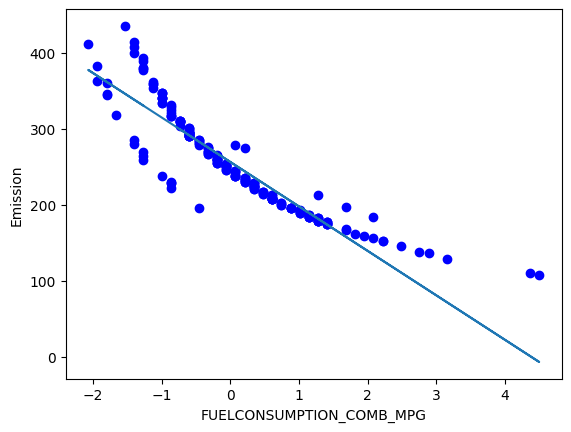

In [61]:
# plotting test set
X_test_2 = X_test[:,[1]]
plt.scatter(X_test_2.reshape(-1,1),y_test,color='blue')
plt.plot(X_test_2,coef_2[0]*X_test_2+intercept_2)
plt.xlabel('FUELCONSUMPTION_COMB_MPG')
plt.ylabel('Emission')
plt.show()